# Model Test #3
* Cleaned/imputed negative values
* Did not balance classes

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-05-31 08:54:43.087387


In [2]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
pct = pd.read_csv('s3://bleeding-hearts/workingdata/merge_pct.csv')
est.info()
pct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(1), int64(143), object(4)
memory usage: 20.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(102), int64(42), object(4)
memory usage: 20.6+ MB


In [3]:
for i in [est,pct]:
    i.drop(columns=['Unnamed: 0'],inplace=True)
    cols=list(i)
    all_miss = []
    for c in cols:
        if i[c].dtypes != object:
            i.loc[i[c] < 0, c] = np.nan
        if len(i) - i[c].count() == len(i):
            all_miss.append(c)
    i.drop(columns=all_miss,inplace=True)
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 127 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(123), object(4)
memory usage: 17.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 131 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(127), object(4)
memory usage: 18.2+ MB


In [4]:
def assess_missing(df):
    missing_dict = {}
    cols=list(df)
    for c in cols:
        if len(df) - df[c].count() > 0:
             missing_dict[c] = ((len(df) - df[c].count())/len(df))*100
    return missing_dict

In [5]:
est_missing = assess_missing(est)
est_missing

{'COMMUTING TO WORK_Mean travel time to work (minutes)': 0.35149384885764495,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Median household income (dollars)': 0.19771528998242532,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Mean household income (dollars)': 0.21968365553602814,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings_Mean earnings (dollars)': 0.2251757469244288,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Social Security_Mean Social Security income (dollars)': 0.5437170474516696,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With retirement income_Mean retirement income (dollars)': 0.8018453427065025,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Supplemental Security Income_Mean Supplemental Security Income (dollars)': 10.209797891036906,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With cash public assistance income_Mean cash

In [6]:
pct_missing = assess_missing(pct)
pct_missing

{'EMPLOYMENT STATUS_Population 16 years and over_In labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_Not in labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate': 0.04942882249560633,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force': 0.04393673110720562,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force': 0.04393673110720562,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed': 0.043936

In [7]:
#column names are the same in est and pct
cols=list(est)
cat_cols=cols[-8:-5]
num_cols=cols[-4:]
print(cat_cols,'\n\n',num_cols)

['Child Opportunity Levels, education domain, nationally- normed', 'Child Opportunity Levels, health and environment domain, nationally-normed', 'Child Opportunity Levels, social and economic domain, nationally-normed'] 

 ['Child Opportunity Scores, education domain, nationally- normed', 'Child Opportunity Scores, health and environment domain, nationally-normed', 'Child Opportunity Scores, social and economic domain, nationally-normed', 'Child Opportunity Scores, overall COI, nationally-normed']


In [8]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [9]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [10]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [11]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Very Low','Low','Moderate','High','Very High'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

Target = Child Opportunity Levels, education domain, nationally- normed
(14566, 126) (14566,)
(3642, 126) (3642,)
F1 SCORE SVC: 0.8779657293497364


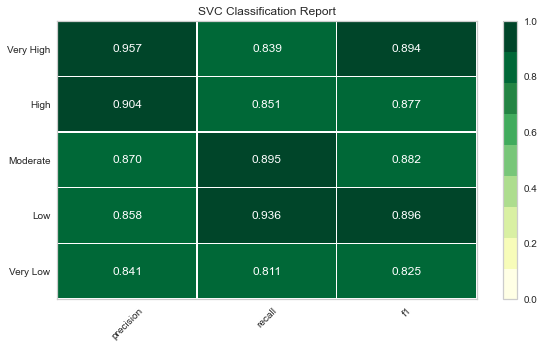

F1 SCORE NuSVC: 0.7939916520210897


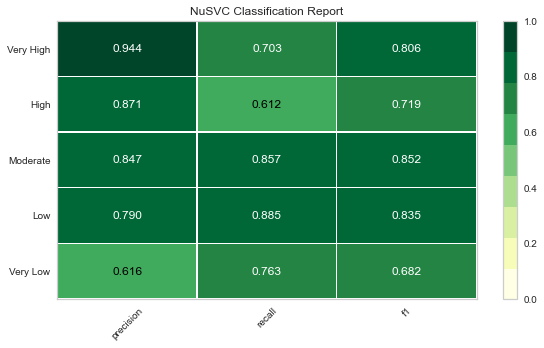

F1 SCORE LinearSVC: 0.8326010544815465


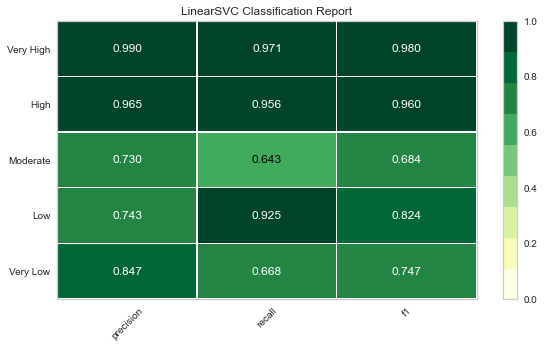

F1 SCORE SGDClassifier: 0.679756151142355


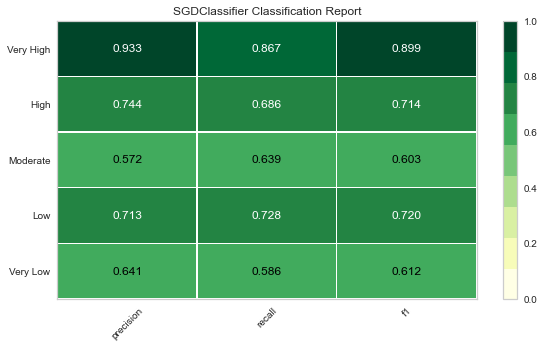

F1 SCORE KNeighborsClassifier: 0.6705294376098418


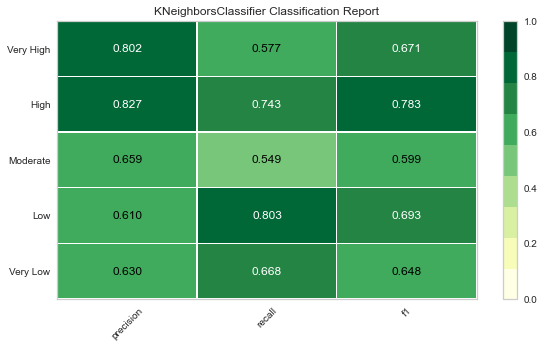

F1 SCORE LogisticRegression: 0.6162675746924429


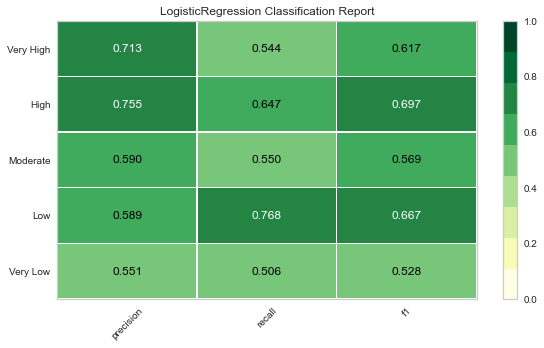

F1 SCORE LogisticRegressionCV: 0.8795035149384886


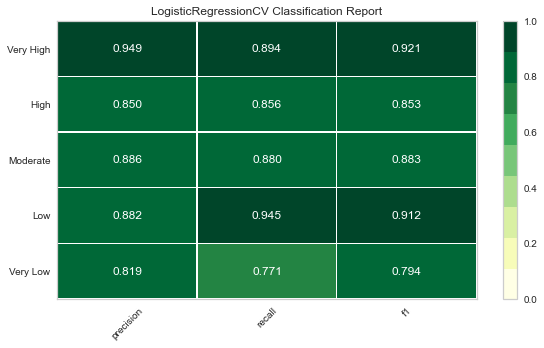

F1 SCORE BaggingClassifier: 1.0


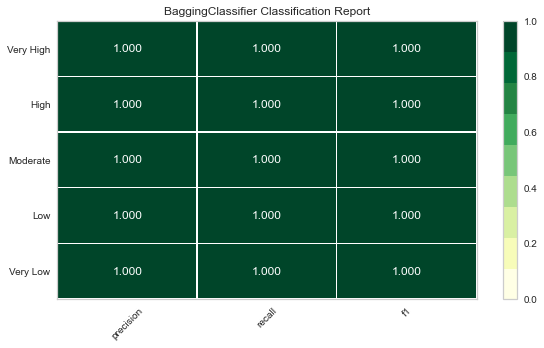

F1 SCORE ExtraTreesClassifier: 1.0


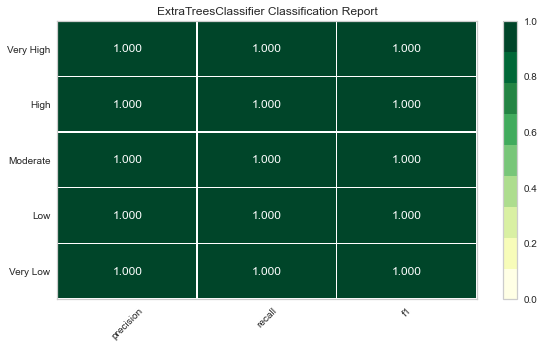

F1 SCORE RandomForestClassifier: 1.0


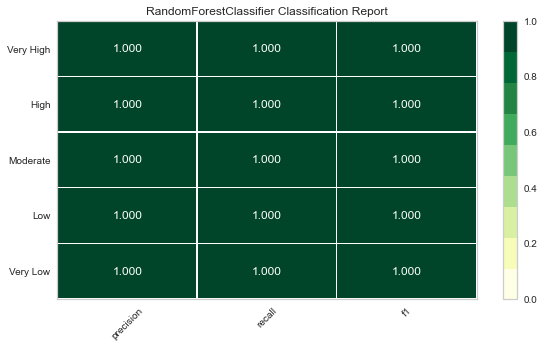

Target = Child Opportunity Levels, health and environment domain, nationally-normed
(14566, 126) (14566,)
(3642, 126) (3642,)
F1 SCORE SVC: 0.8866432337434095


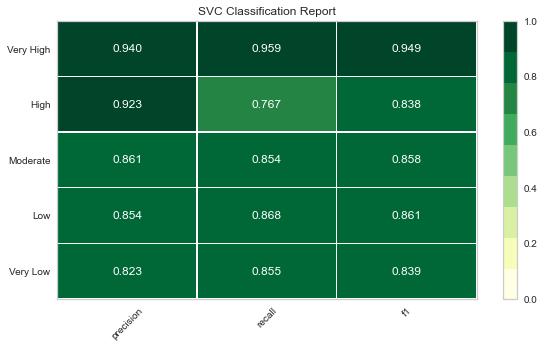

error in NuSVC(gamma='auto')
F1 SCORE LinearSVC: 0.8418826889279437


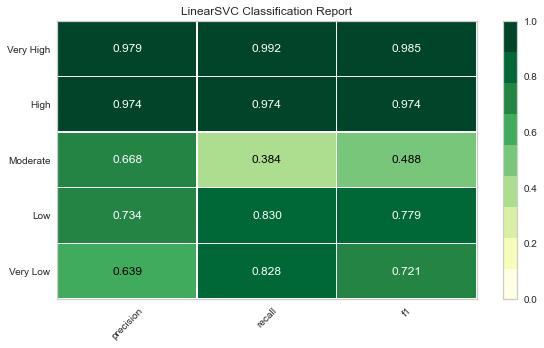

F1 SCORE SGDClassifier: 0.6667398945518453


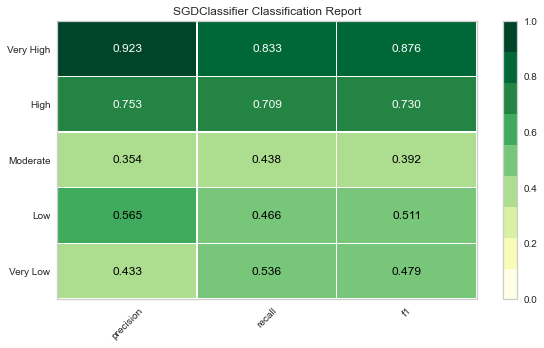

F1 SCORE KNeighborsClassifier: 0.6698703866432337


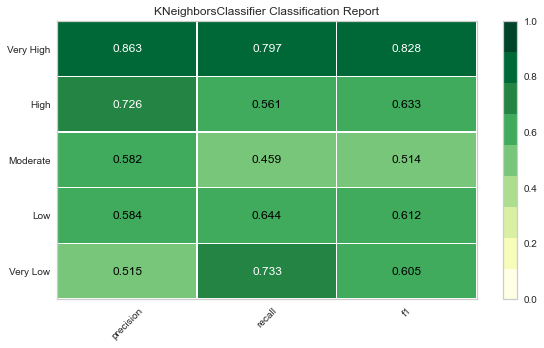

F1 SCORE LogisticRegression: 0.5878734622144113


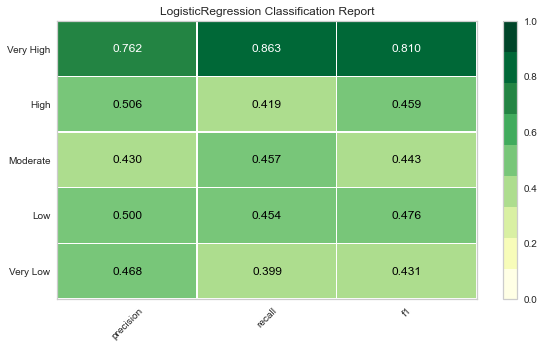

F1 SCORE LogisticRegressionCV: 0.8586335676625659


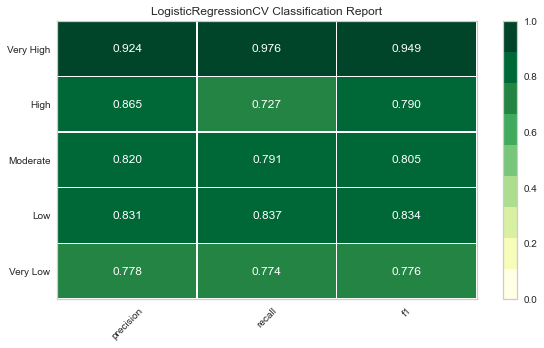

F1 SCORE BaggingClassifier: 1.0


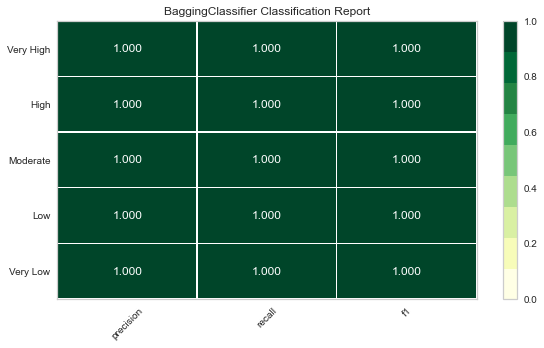

F1 SCORE ExtraTreesClassifier: 1.0


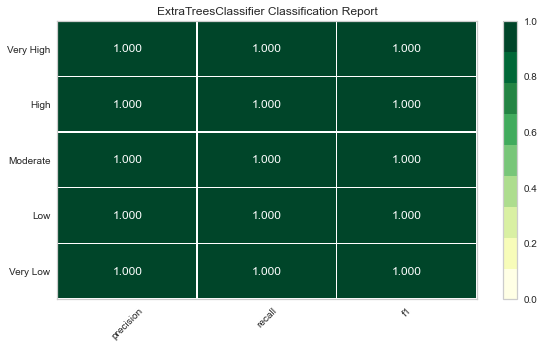

F1 SCORE RandomForestClassifier: 1.0


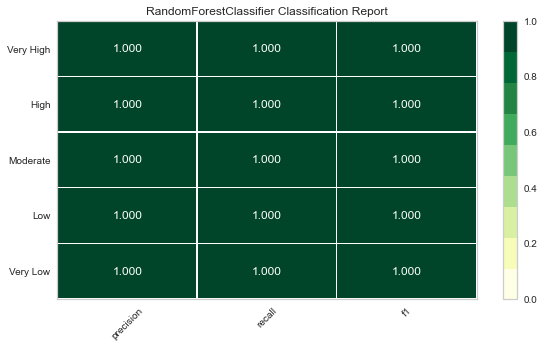

Target = Child Opportunity Levels, social and economic domain, nationally-normed
(14566, 126) (14566,)
(3642, 126) (3642,)
F1 SCORE SVC: 0.835621704745167


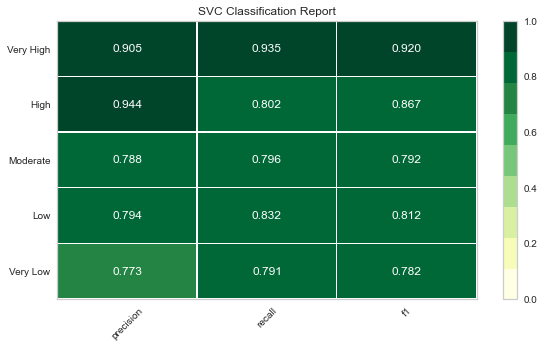

F1 SCORE NuSVC: 0.7618079964850616


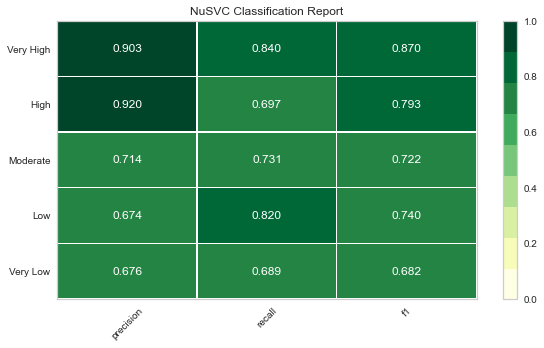

F1 SCORE LinearSVC: 0.8408391915641477


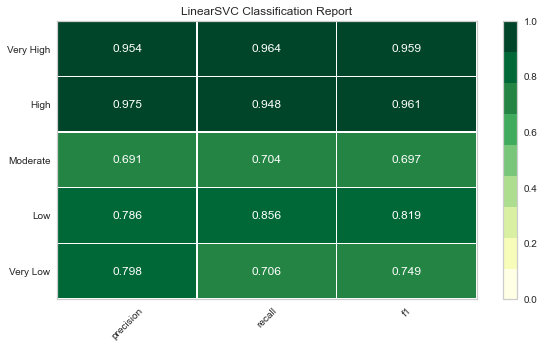

F1 SCORE SGDClassifier: 0.7198484182776801


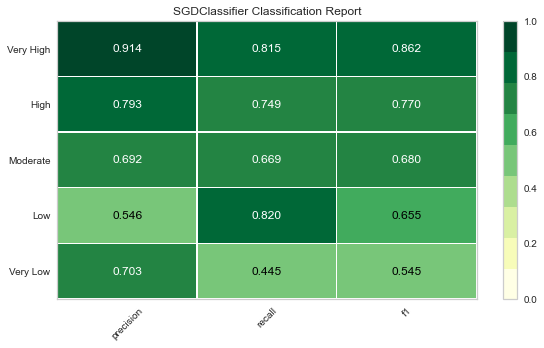

F1 SCORE KNeighborsClassifier: 0.7479679261862918


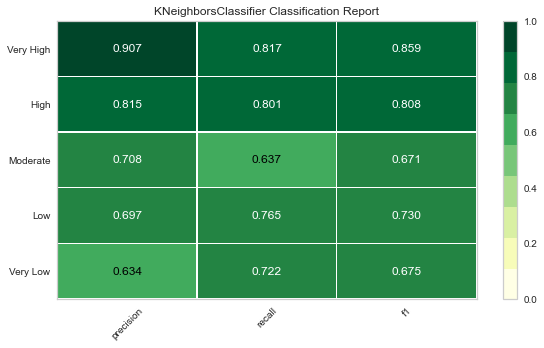

F1 SCORE LogisticRegression: 0.7588971880492091


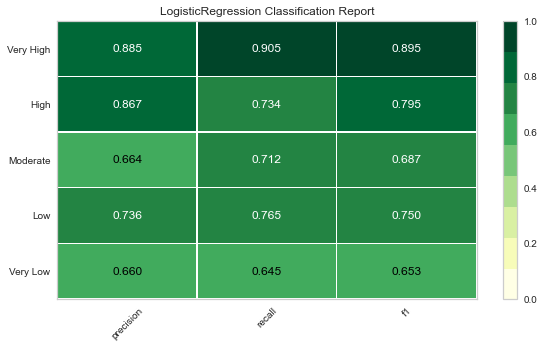

F1 SCORE LogisticRegressionCV: 0.8579745166959578


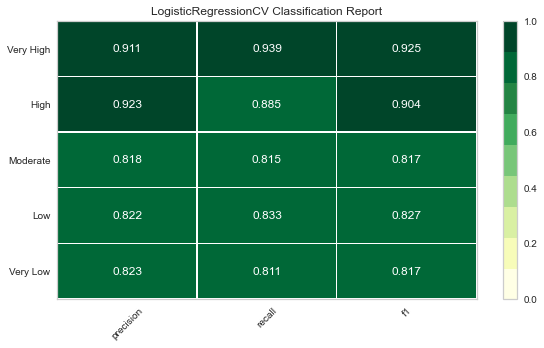

F1 SCORE BaggingClassifier: 1.0


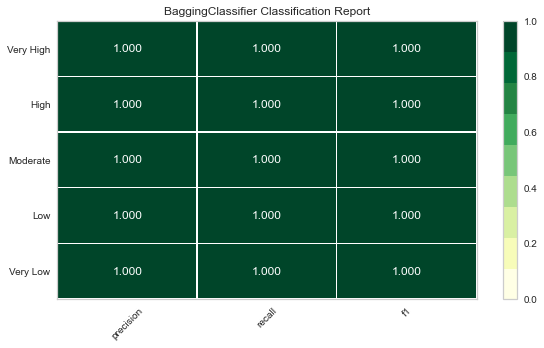

F1 SCORE ExtraTreesClassifier: 1.0


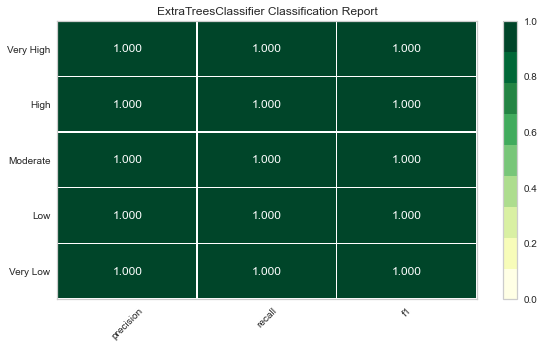

F1 SCORE RandomForestClassifier: 1.0


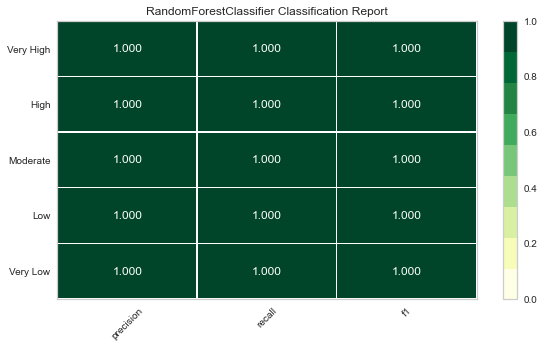

In [12]:
for i in cat_cols:
    print('Target =', i)
    X = est.loc[:, est.columns != i]
    y = est[i]
    train_test(X,y)
    for model in models:
        try:
            score_model(X, y, model)
            visualize_model(X, y, model)
        except:
            print("error in",model)

Target = Child Opportunity Levels, education domain, nationally- normed
(14566, 130) (14566,)
(3642, 130) (3642,)
F1 SCORE SVC: 0.8895540421792618


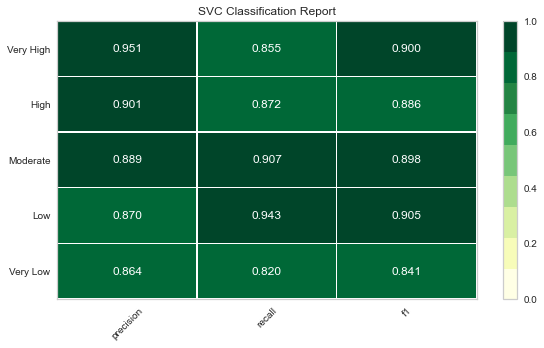

F1 SCORE NuSVC: 0.7898176625659051


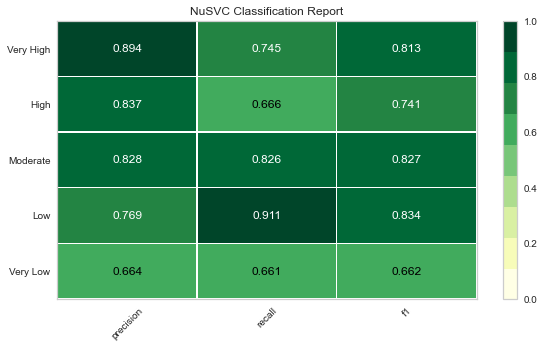

F1 SCORE LinearSVC: 0.8534710017574693


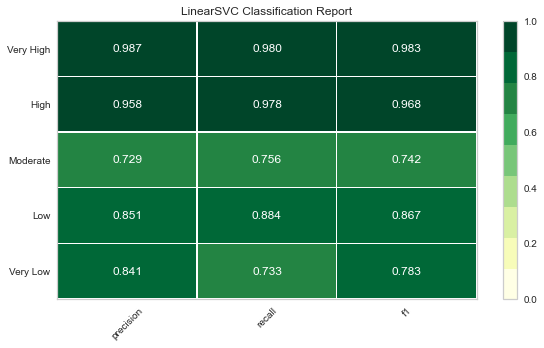

F1 SCORE SGDClassifier: 0.7462653778558875


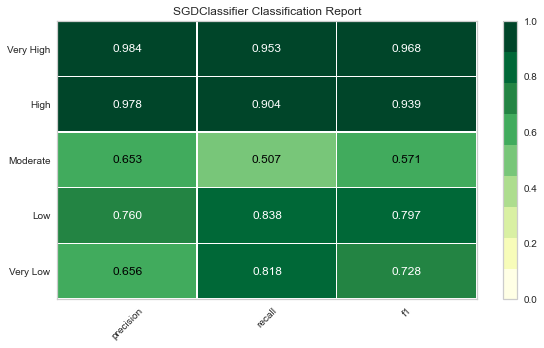

F1 SCORE KNeighborsClassifier: 0.6693760984182777


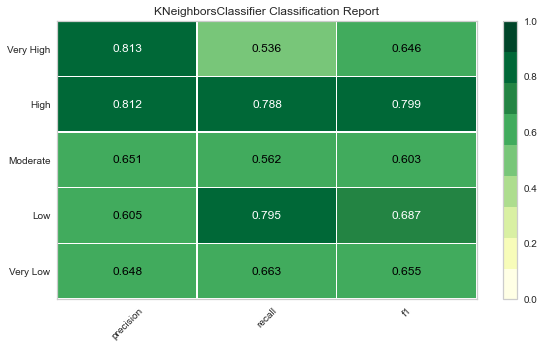

F1 SCORE LogisticRegression: 0.9645760105448155


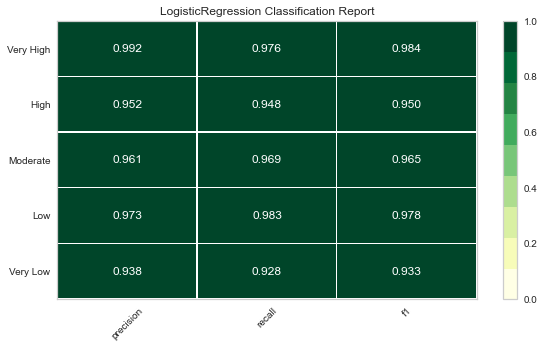

F1 SCORE LogisticRegressionCV: 0.9963752196836555


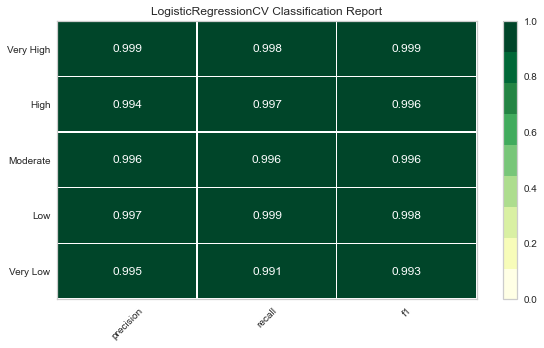

F1 SCORE BaggingClassifier: 1.0


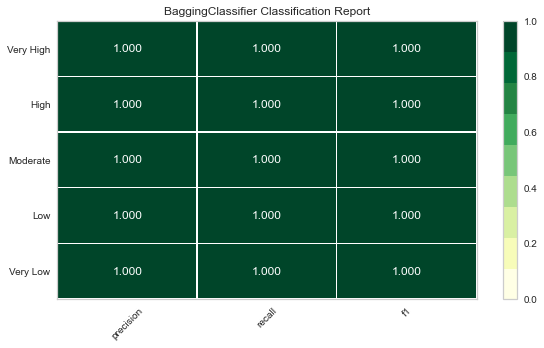

F1 SCORE ExtraTreesClassifier: 1.0


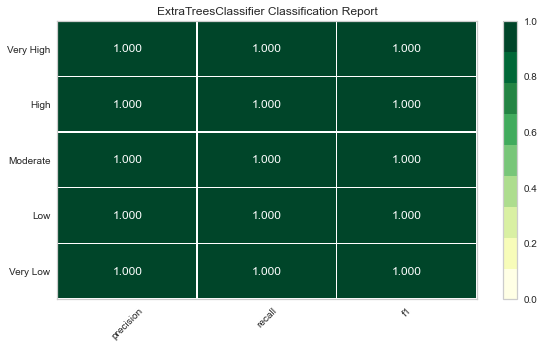

F1 SCORE RandomForestClassifier: 1.0


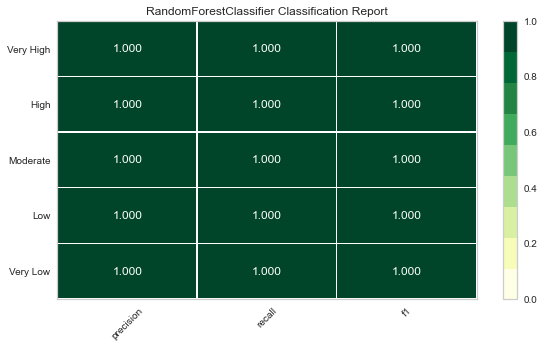

Target = Child Opportunity Levels, health and environment domain, nationally-normed
(14566, 130) (14566,)
(3642, 130) (3642,)
F1 SCORE SVC: 0.9004833040421792


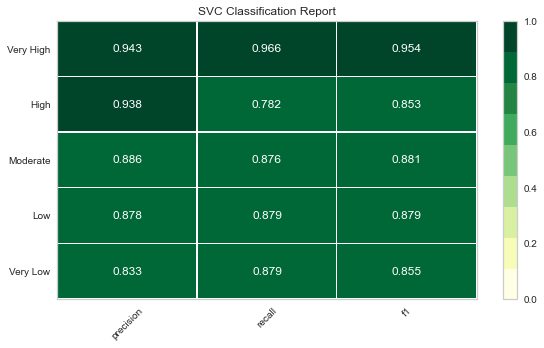

error in NuSVC(gamma='auto')
F1 SCORE LinearSVC: 0.8461115992970123


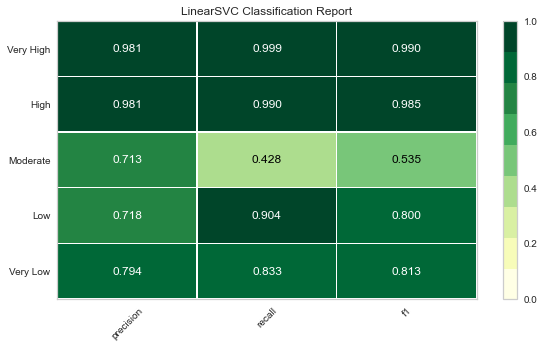

F1 SCORE SGDClassifier: 0.7482425307557118


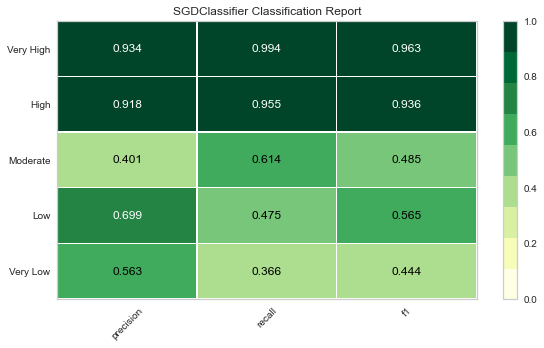

F1 SCORE KNeighborsClassifier: 0.6665202108963093


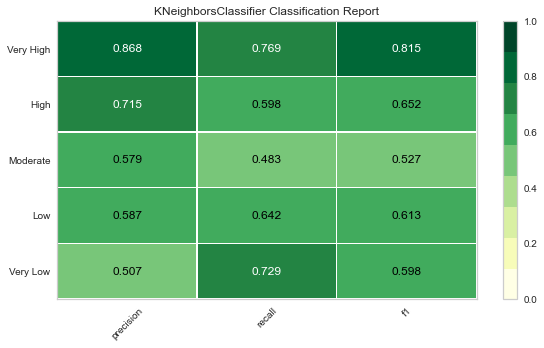

F1 SCORE LogisticRegression: 0.9718255711775043


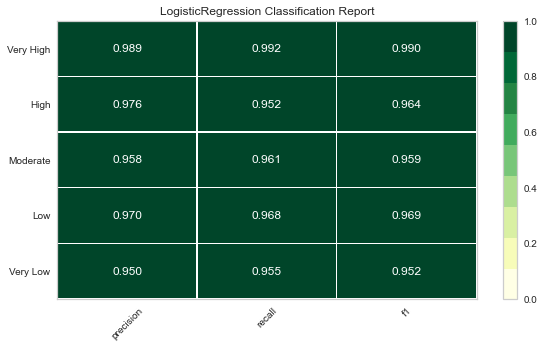

F1 SCORE LogisticRegressionCV: 0.9958260105448155


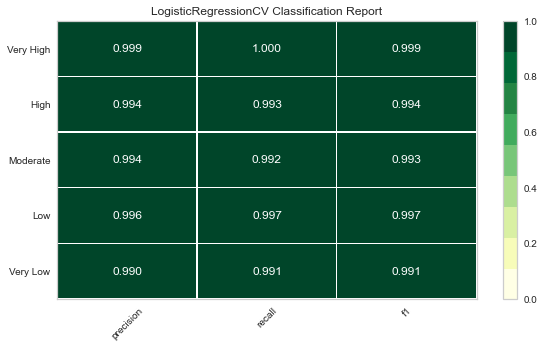

F1 SCORE BaggingClassifier: 1.0


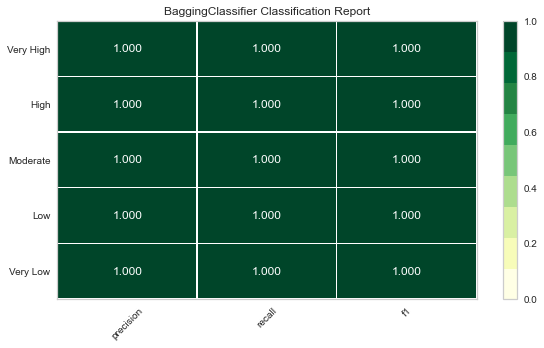

F1 SCORE ExtraTreesClassifier: 1.0


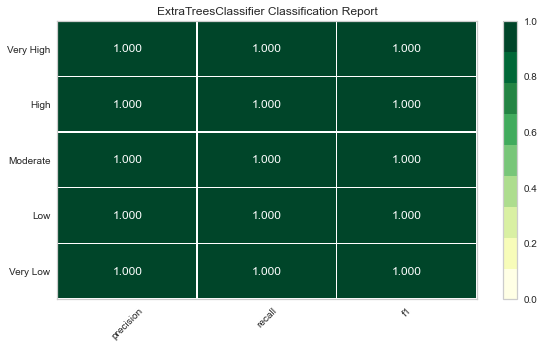

F1 SCORE RandomForestClassifier: 1.0


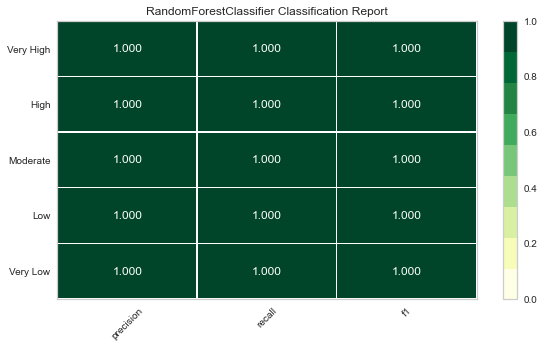

Target = Child Opportunity Levels, social and economic domain, nationally-normed
(14566, 130) (14566,)
(3642, 130) (3642,)
F1 SCORE SVC: 0.8334797891036907


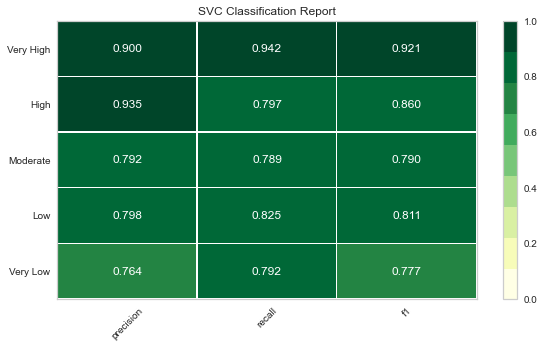

F1 SCORE NuSVC: 0.7460456942003515


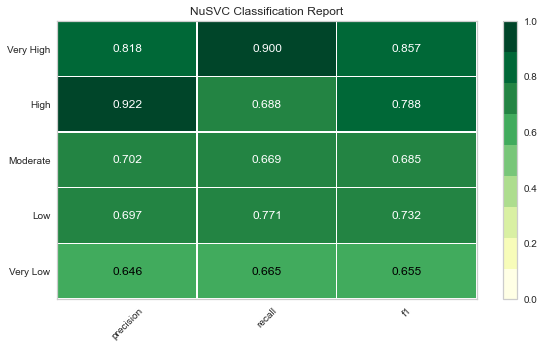

F1 SCORE LinearSVC: 0.8445188927943761


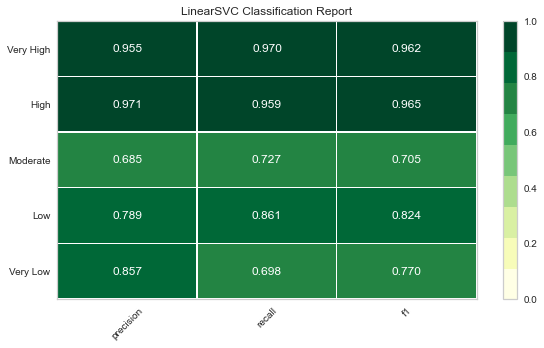

F1 SCORE SGDClassifier: 0.836225834797891


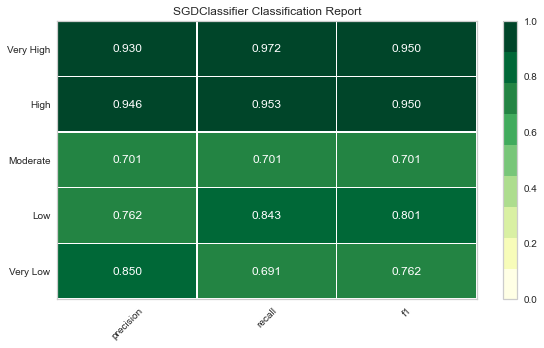

F1 SCORE KNeighborsClassifier: 0.7481876098418277


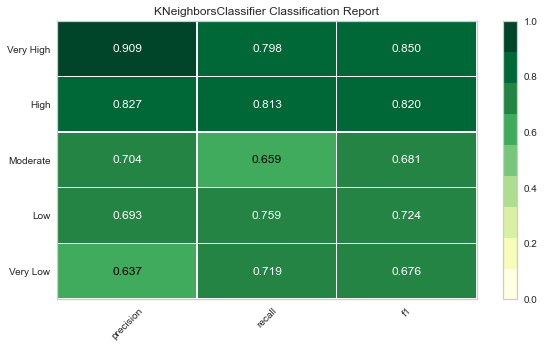

F1 SCORE LogisticRegression: 0.9350285588752196


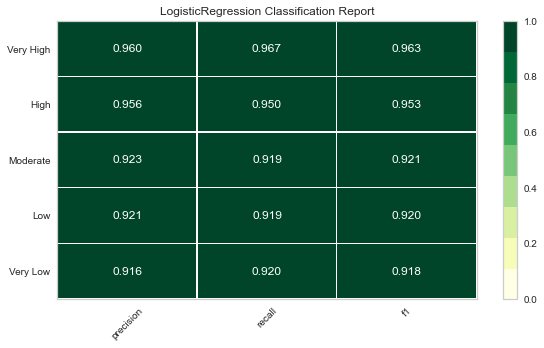

F1 SCORE LogisticRegressionCV: 0.9911028119507909


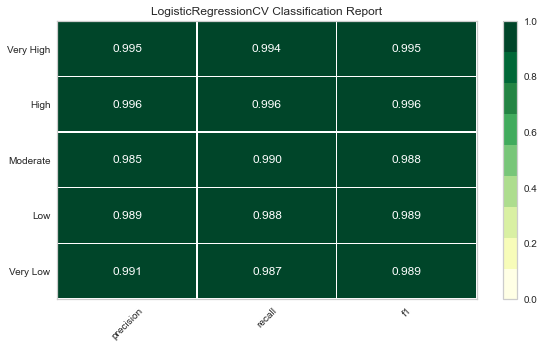

F1 SCORE BaggingClassifier: 1.0


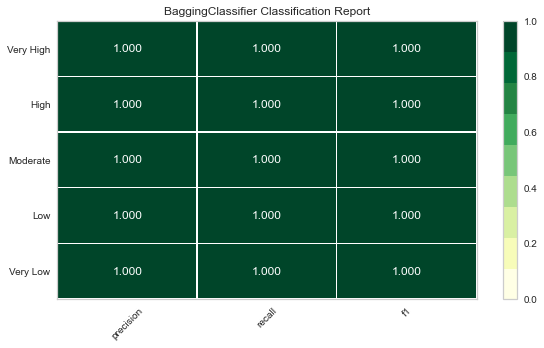

F1 SCORE ExtraTreesClassifier: 1.0


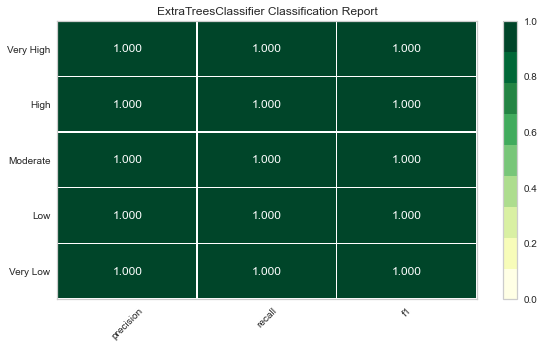

F1 SCORE RandomForestClassifier: 1.0


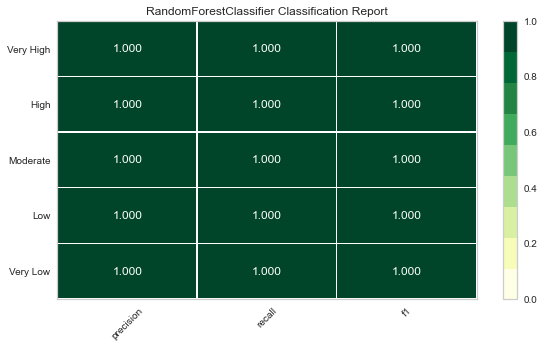

In [13]:
for i in cat_cols:
    print('Target =', i)
    X = pct.loc[:, pct.columns != i]
    y = pct[i]
    train_test(X,y)
    for model in models:
        try:
            score_model(X, y, model)
            visualize_model(X, y, model)
        except:
            print("error in",model)